# Read from the storage database

In [1]:
import numpy as np
import pandas as pd
import pymysql
import sqlalchemy as sql
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns

class NGDataObject():
    
    def __init__(self, host, database, user, password):
        self.password = password
        self.host = host
        self.database = database
        self.user = user
        
    def get_from_database(self, query):
        """
        Connects to the storage database and retrieves the data for the given date.
        INPUT:
            - query: SQL query as string
        OUTPUT:
            - pandas dataframe
        """
        connect_string = 'mysql+pymysql://%(user)s:%(pw)s@%(host)s/%(db)s'% {
            "user": self.user, 
            "pw": self.password, 
            "host": self.host, 
            "db": self.database}
        
        sql_engine = sql.create_engine(connect_string)

        df = pd.read_sql(query, sql_engine)
        
        # convert to datetime
        df['time'] = pd.to_datetime(df['time'])
        # set index as time
        df.set_index('time', drop=True, inplace=True)
        return df
        
    
            
    def resample_10_seconds(self, df, cols):
        """
        Takes the a grouped df (grouped by day) and resamples the columns cols in 10s
        OUTPUT:
            - dataframe 
        """

        d = {}
        range_start = f'{day} 00:00:00'
        range_end = f'{day} 23:59:00'
        # resample 24 hours in steps of 10 s
        s = pd.date_range(start=range_start, end=range_end, freq='10S')
        df_out = pd.DataFrame(pd.Series(s, name='time')).set_index('time')
        for col in cols:
            d[col] = df[col].resample('10S').mean()

        this_d = pd.DataFrame(d)

        df_out = df_out.merge(this_d, left_on=df_out.index, right_on=this_d.index, how='outer')

        return df_out
     
    def save_to_csv(self, path, dataframe):
        """
        Saves the dataframe to the path .csv.
        """
        dataframe.to_csv(f'{path}.csv')

In [2]:
import matplotlib
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

# ETL settings

In [3]:
# for which day to perform the analysis
day = "2019-12-16" # day to extract from the db


# read password and user to database
credentials_file = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'
credentials = pd.read_csv(credentials_file, header=0)
user = credentials['username'].values[0]
pw = credentials['password'].values[0]
host="twofast-RPi3-0"  # your host
user=user  # username
passwd=pw  # password
db="NG_twofast_DB" # name of the database

# connect to DB
con = NGDataObject(host = host, database=db, user=user, password=pw)

# get dose
query = "SELECT * FROM data_dose WHERE DATE(time) = '%(t)s'" % {"t": day}
# data_dose = con.get_from_database(query=query)
# data_dose_rs = con.resample_10_seconds(df=data_dose, cols=['dose', 'dose_voltage', 'dose_corrected'])

# get HV
query = "SELECT * FROM data_HV WHERE DATE(time) = '%(t)s'" % {"t": day}
data_hv = con.get_from_database(query=query)
# data_hv_rs = con.resample_10_seconds(df=data_hv, cols=['HV_voltage', 'HV_current'])

# get pressure
query = "SELECT * FROM data_pressure WHERE DATE(time) = '%(t)s'" % {"t": day}
data_pressure = con.get_from_database(query=query)
# data_pressure_rs = con.resample_10_seconds(df=data_pressure, cols=['pressure_IS', 'pressure_VC', 'pressure_IS_corrected'])

# Plots

In [3]:
path = '/Users/hkromer/02_PhD/04_Publiations/03_Presentations/2019/2019-12-17.Spiez/2019-12-02.HV.png'

## Plot pressure whole day

/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


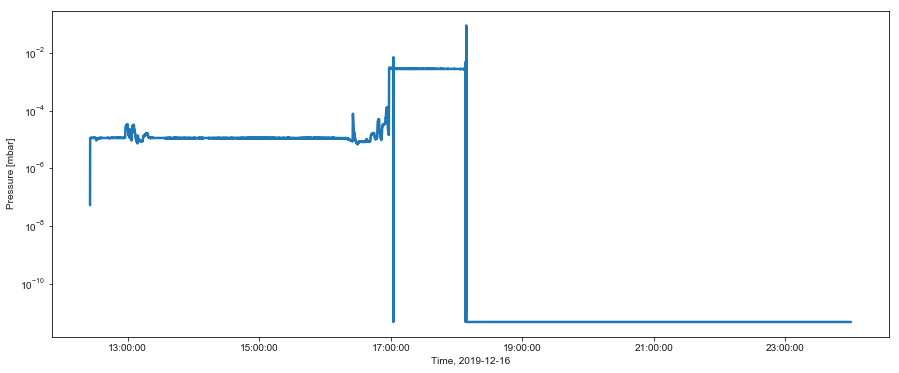

In [4]:
fig, ax = plt.subplots(figsize=(15,6))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_pressure.index, y='pressure_IS_corrected', data=data_pressure, ax=ax)
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
ax.set(yscale="log")
ax.set_ylabel('Pressure [mbar]')
ax.set_xlabel(f'Time, {day}')
plt.savefig(f'{path}', dpi=1200, format='png')

## Plot pressure and HV 

/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


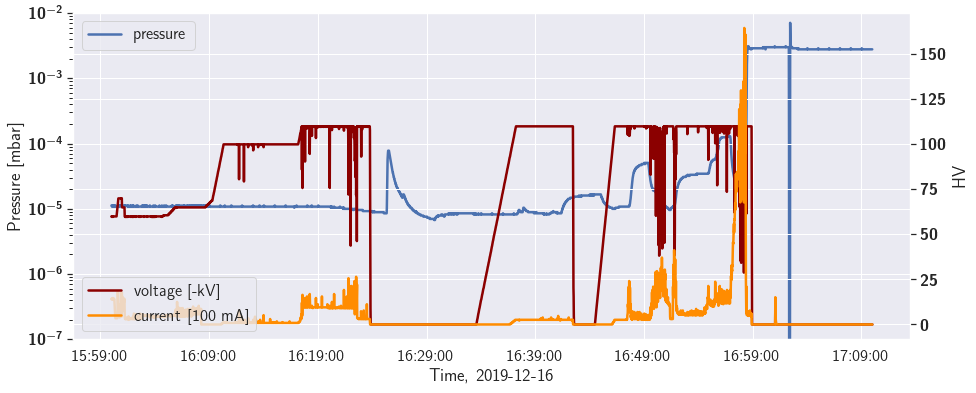

In [6]:
path = '/Users/hkromer/02_PhD/04_Publiations/03_Presentations/2019/2019-12-17.Spiez/2019-12-02.HV.png'
import seaborn as sns
time_start = '2019-12-16 16:00:00'
time_end = '2019-12-16 17:10:00'

df_hv = data_hv.loc[time_start:time_end,:]
# scale current by 100
df_hv['HV_current_x100'] = df_hv['HV_current']*100.0
df_pressure = data_pressure.loc[time_start:time_end,:]

fig, ax = plt.subplots(figsize=(15,6))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=df_pressure.index, y='pressure_IS_corrected', data=df_pressure, ax=ax, label='pressure')
plt.legend(loc='upper left')

ax2 = ax.twinx()
sns.lineplot(x=df_hv.index, y='HV_voltage', data=df_hv, ax=ax2, color='darkred', label='voltage [-kV]')
sns.lineplot(x=df_hv.index, y='HV_current_x100', data=df_hv, ax=ax2, color='darkorange', label='current [100 mA]')
plt.legend(loc='lower left')

ax.set(yscale="log")
ax.set_ylabel('Pressure [mbar]')
ax2.set_ylabel('HV')

ax.set_xlabel(f'Time, {day}')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
ax.set_ylim(1e-7, 1e-2)

# plt.savefig(f'{path}pressure_hv_day.png', dpi=1200, format='png')
plt.show()

# Plot HV only

In [11]:
data_hv_rs = con.resample_10_seconds(df=data_hv, cols=['HV_voltage', 'HV_current'])
data_hv_rs.head()

,key_0,HV_voltage,HV_current
0,2019-12-16 00:00:00,NaN,NaN
1,2019-12-16 00:00:10,NaN,NaN
2,2019-12-16 00:00:20,NaN,NaN
3,2019-12-16 00:00:30,NaN,NaN
4,2019-12-16 00:00:40,NaN,NaN


In [7]:
time_start = '2019-12-16 13:00:00'
time_end = '2019-12-16 17:00:00'

this_df_hv = data_hv_rs.loc[time_start:time_end,:]
# scale current by 100
this_df_hv['HV_current_x100'] = data_hv_rs['HV_current']*100.0

data_hv.head()

/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,HV_voltage,HV_current
time,,,
2019-12-16 12:25:15.721465,12359305,0.0,0.0
2019-12-16 12:25:16.721033,12359306,0.0,0.0
2019-12-16 12:25:30.121766,12359307,0.0,0.0
2019-12-16 12:25:31.125856,12359308,0.0,0.0
2019-12-16 12:25:32.125363,12359309,0.0,0.0


/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


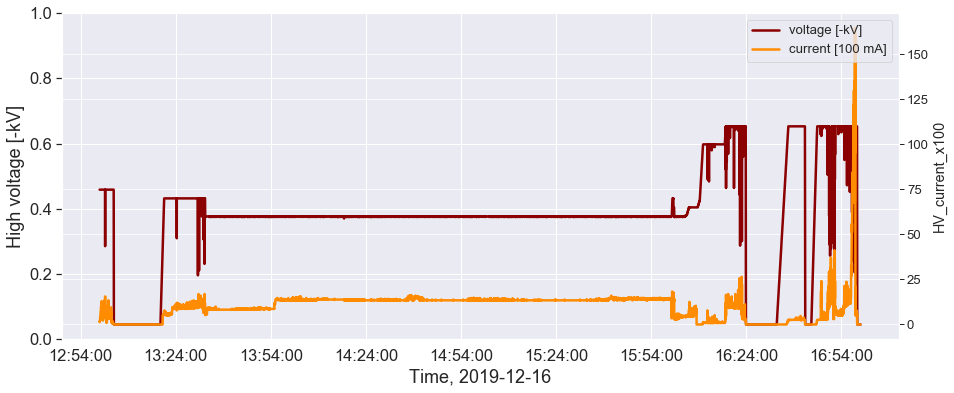

In [5]:



fig, ax = plt.subplots(figsize=(15,6))

sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

ax2 = ax.twinx()
sns.lineplot(x=this_df_hv.index, y='HV_voltage', data=this_df_hv, ax=ax2, color='darkred', label='voltage [-kV]')
sns.lineplot(x=this_df_hv.index, y='HV_current_x100', data=this_df_hv, ax=ax2, color='darkorange', label='current [100 mA]')
plt.legend(loc='upper right')

ax.set_ylabel('High voltage [-kV]')


ax.set_xlabel(f'Time, {day}')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))


# plt.savefig(f'{path}pressure_hv_day.png', dpi=1200, format='png')
plt.show()

# 2019-12-02 for Spiez presentation

In [104]:
# for which day to perform the analysis
day = "2019-12-02" # day to extract from the db


# read password and user to database
credentials_file = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'
credentials = pd.read_csv(credentials_file, header=0)
user = credentials['username'].values[0]
pw = credentials['password'].values[0]
host="twofast-RPi3-0"  # your host
user=user  # username
passwd=pw  # password
db="NG_twofast_DB" # name of the database

# connect to DB
con = NGDataObject(host = host, database=db, user=user, password=pw)


# get HV
query = "SELECT * FROM data_HV WHERE DATE(time) = '%(t)s'" % {"t": day}
data_hv = con.get_from_database(query=query)
# data_hv_rs = con.resample_10_seconds(df=data_hv, cols=['HV_voltage', 'HV_current'])


AttributeError: 'DataFrame' object has no attribute 'save_to_csv'

/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


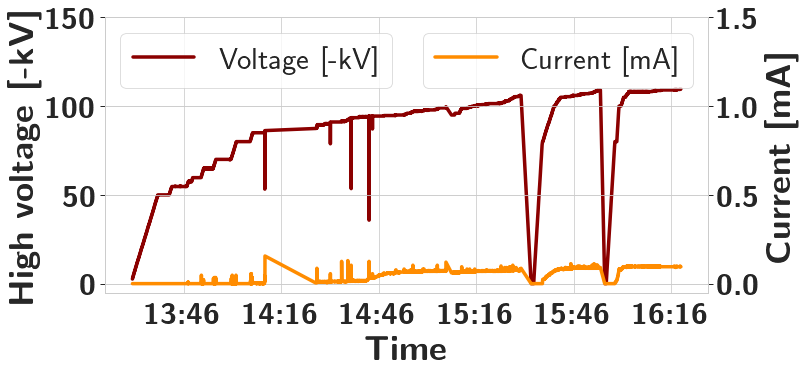

In [105]:
fname = '/Users/hkromer/02_PhD/04_Publiations/03_Presentations/2019/2019-12-17.Spiez/2019-12-02.HV_conditioning.png'

import matplotlib
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


time_start = '2019-12-02 12:00:00'
time_end = '2019-12-02 16:19:00'

this_df_hv = data_hv.loc[time_start:time_end,:]
# scale current by 100
this_df_hv['HV_current_x100'] = data_hv['HV_current']*100.0



fig, ax = plt.subplots(figsize=(12,6))
fs = 35
ax2 = ax.twinx()
# sns.lineplot(x=this_df_hv.index, y='HV_voltage', data=this_df_hv, ax=ax, color='darkred', label='voltage [-kV]')
ax.plot(this_df_hv.index, this_df_hv['HV_voltage'].values, color='darkred', label='Voltage [-kV]', linewidth=3.5)
# sns.lineplot(x=this_df_hv.index, y='HV_current_x100', data=this_df_hv, ax=ax, color='darkorange', label='current [100 mA]')
ax2.plot(this_df_hv.index, this_df_hv['HV_current'].values, color='darkorange', label='Current [mA]', linewidth=3.5)

ax.set_xlabel(r'\textbf{Time}', fontsize=fs)
ax.set_ylabel(r'\textbf{High voltage [-kV]}', fontsize=fs)
ax2.set_ylabel(r'\textbf{Current [mA]}', fontsize=fs)

# ax.set_xlabel(f'Time, {day}')
ax.xaxis.set_major_formatter(md.DateFormatter(r'\textbf{%H:%M}'))

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_ylim(-5,150)
ax2.set_ylim(-0.05,1.5)
plt.tight_layout()
plt.savefig(f'{fname}', dpi=1200, format='png')
plt.show()

In [107]:
# save the data for Robert
df_save = this_df_hv[['HV_voltage', 'HV_current']]
path = '/Users/hkromer/02_PhD/04_Publiations/03_Presentations/2019/2019-12-17.Spiez/2019-12-02.HV_conditioning'
df_save.to_csv(f'{path}.csv')